In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from copy import deepcopy

import mat73
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pygraphviz as pgv
from IPython.display import Image
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation
from pgmpy.metrics import BayesianModelProbability
from pgmpy.models import BayesianNetwork
from tqdm.auto import tqdm

from EinsumNetwork import Graph

In [3]:
df_train = pd.read_csv("dataset/coco2017-cooccurences-train.csv").iloc[:, 8:]
df_train.columns = [
    col.split("-")[0].replace("[", "").replace("]", "").upper()
    for col in df_train.columns
]

df_valid = pd.read_csv("dataset/coco2017-cooccurences-valid.csv").iloc[:, 8:]
df_valid.columns = df_train.columns

In [4]:
mat = mat73.loadmat("outputs/coco2017_bin_20-Jun-2023.mat")["t_hat"]

In [20]:
BIN_G = nx.DiGraph()

BIN_G.add_nodes_from([i for i in range(1, len(mat["t"]) + 1)])

map1 = {k: v.replace(" ", "\\n") for k, v in enumerate(df_train.columns, 1)}
map2 = {k: f"{k}[{v}]" for k, v in enumerate(mat["nsyms"][len(df_train.columns):], len(df_train.columns) + 1)}
maps = {**map1, **map2}


edges = []
for i, src in enumerate(mat["t"], 1):
    for tgts in src:
        if isinstance(tgts, np.ndarray):
            tgts = tgts.astype(np.int64)
            for tgt in tgts:
                BIN_G.add_edge(i, tgt)

BIN_G = nx.relabel_nodes(BIN_G, maps)

In [6]:
graph_gviz = pgv.AGraph(directed=True)

graph_gviz.add_nodes_from(BIN_G.nodes)
graph_gviz.add_edges_from(BIN_G.edges)


graph_gviz.graph_attr["rank"] = "same"
graph_gviz.graph_attr["rankdir"] = "TB"
graph_gviz.graph_attr["overlap"] = "false"
graph_gviz.graph_attr["ratio"] = "compress"
graph_gviz.node_attr["shape"] = "box"

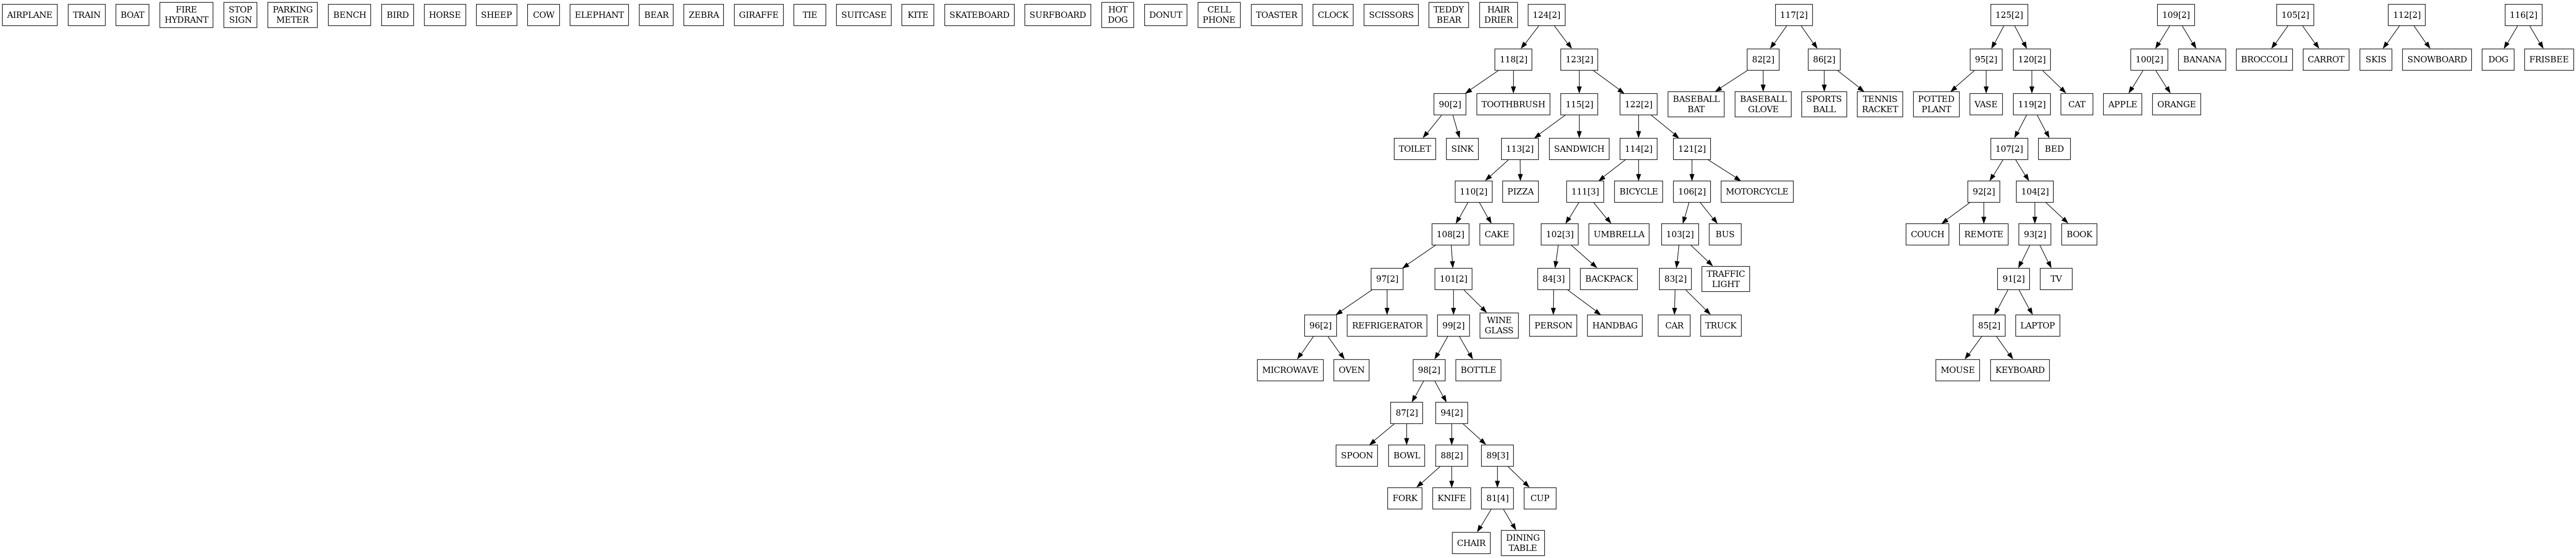

In [7]:
graph_gviz.draw("outputs/bin_g.png", prog="dot")
graph_gviz.draw("outputs/bin_g.pdf", prog="dot")

Image("outputs/bin_g.png")

In [8]:
nodes = list(BIN_G.nodes)
model = BayesianNetwork(BIN_G, latents=nodes[df_train.shape[1] :])

for i, children in enumerate(mat["t"]):
    parent = nodes[i]
    if children[0] is not None:
        j, k = children[0].astype(int) - 1

        table_j, table_k = mat["p"][i][0]

        model.add_cpds(
            TabularCPD(
                nodes[j], table_j.shape[0], table_j, [parent], [table_j.shape[-1]]
            ),
            TabularCPD(
                nodes[k], table_k.shape[0], table_k, [parent], [table_k.shape[-1]]
            ),
        )

for i, table in zip(mat["t0"].astype(int), mat["p0"]):
    i -= 1

    model.add_cpds(TabularCPD(nodes[i], table.shape[0], table[:, None]))

print("BIN-G ready? {}".format(model.check_model()))

BIN-G ready? True


/tmp/ipykernel_3971894/1795749736.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  TabularCPD(
/tmp/ipykernel_3971894/1795749736.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  TabularCPD(


In [9]:
params = 0
for cpd in model.get_cpds():
    params += cpd.values.size

In [10]:
# Supposed to return a DistributionVector
def dfs(
    root: str,
    graph: nx.DiGraph,
    region_graph: nx.DiGraph,
    observed_nodes: list,
    num_repetition=1,
) -> Graph.DistributionVector:
    children = list(graph.successors(root))

    if len(children) <= 0:
        leaf = Graph.DistributionVector([observed_nodes.index(root)])
        leaf.einet_address.replica_idx = 0
        return leaf

    cnodes = []
    scope = []
    for child in children:
        cnodes.append(dfs(child, graph, region_graph, observed_nodes, num_repetition))

        scope.extend(list(cnodes[-1].scope))

    sum_node = Graph.DistributionVector(scope)
    sum_node.einet_address.replica_idx = 0
    
    product_node = Graph.Product(scope)
    region_graph.add_edge(sum_node, product_node)

    for cnode in cnodes:
        cnode.einet_address.replica_idx = 0
        region_graph.add_edge(product_node, cnode)

    """
    for repetition in range(num_repetition):
        product_node = Graph.Product(scope)
        region_graph.add_edge(sum_node, product_node)
        for cnode in cnodes:
            c = deepcopy(cnode)

            c.einet_address.replica_idx = repetition
            region_graph.add_edge(product_node, c)
    """

    return sum_node


def aggregate(region_graph):
    roots = [node for node, in_edge in region_graph.in_degree() if in_edge <= 0]
    for i in range(1, len(roots), 2):
        scope = [*roots[i - 1].scope, *roots[i].scope]

        sum_node = Graph.DistributionVector(scope)

        sum_node.einet_address.replica_idx = 0

        product_node = Graph.Product(scope)

        region_graph.add_edge(sum_node, product_node)
        region_graph.add_edge(product_node, roots[i - 1])
        region_graph.add_edge(product_node, roots[i])

    if len(roots) > 1:
        aggregate(region_graph)

In [11]:
roots = [node for node, in_edge in BIN_G.in_degree if in_edge <= 0]

observed_nodes = list(BIN_G.nodes)[:80]
independent_roots = []

RG = nx.DiGraph()
for root in roots:
    if len(list(BIN_G.successors(root))) <= 0:
        idp_node = Graph.DistributionVector([observed_nodes.index(root)])
        idp_node.einet_address.replica_idx = 0
        RG.add_node(idp_node)
        continue

    dfs(root, BIN_G, RG, observed_nodes)



RG.add_node(idp_node)    

RG_cpy = nx.DiGraph()
RG_cpy.add_nodes_from([node for node, edge_count in RG.in_degree() if edge_count <= 0])

aggregate(RG)
aggregate(RG_cpy)

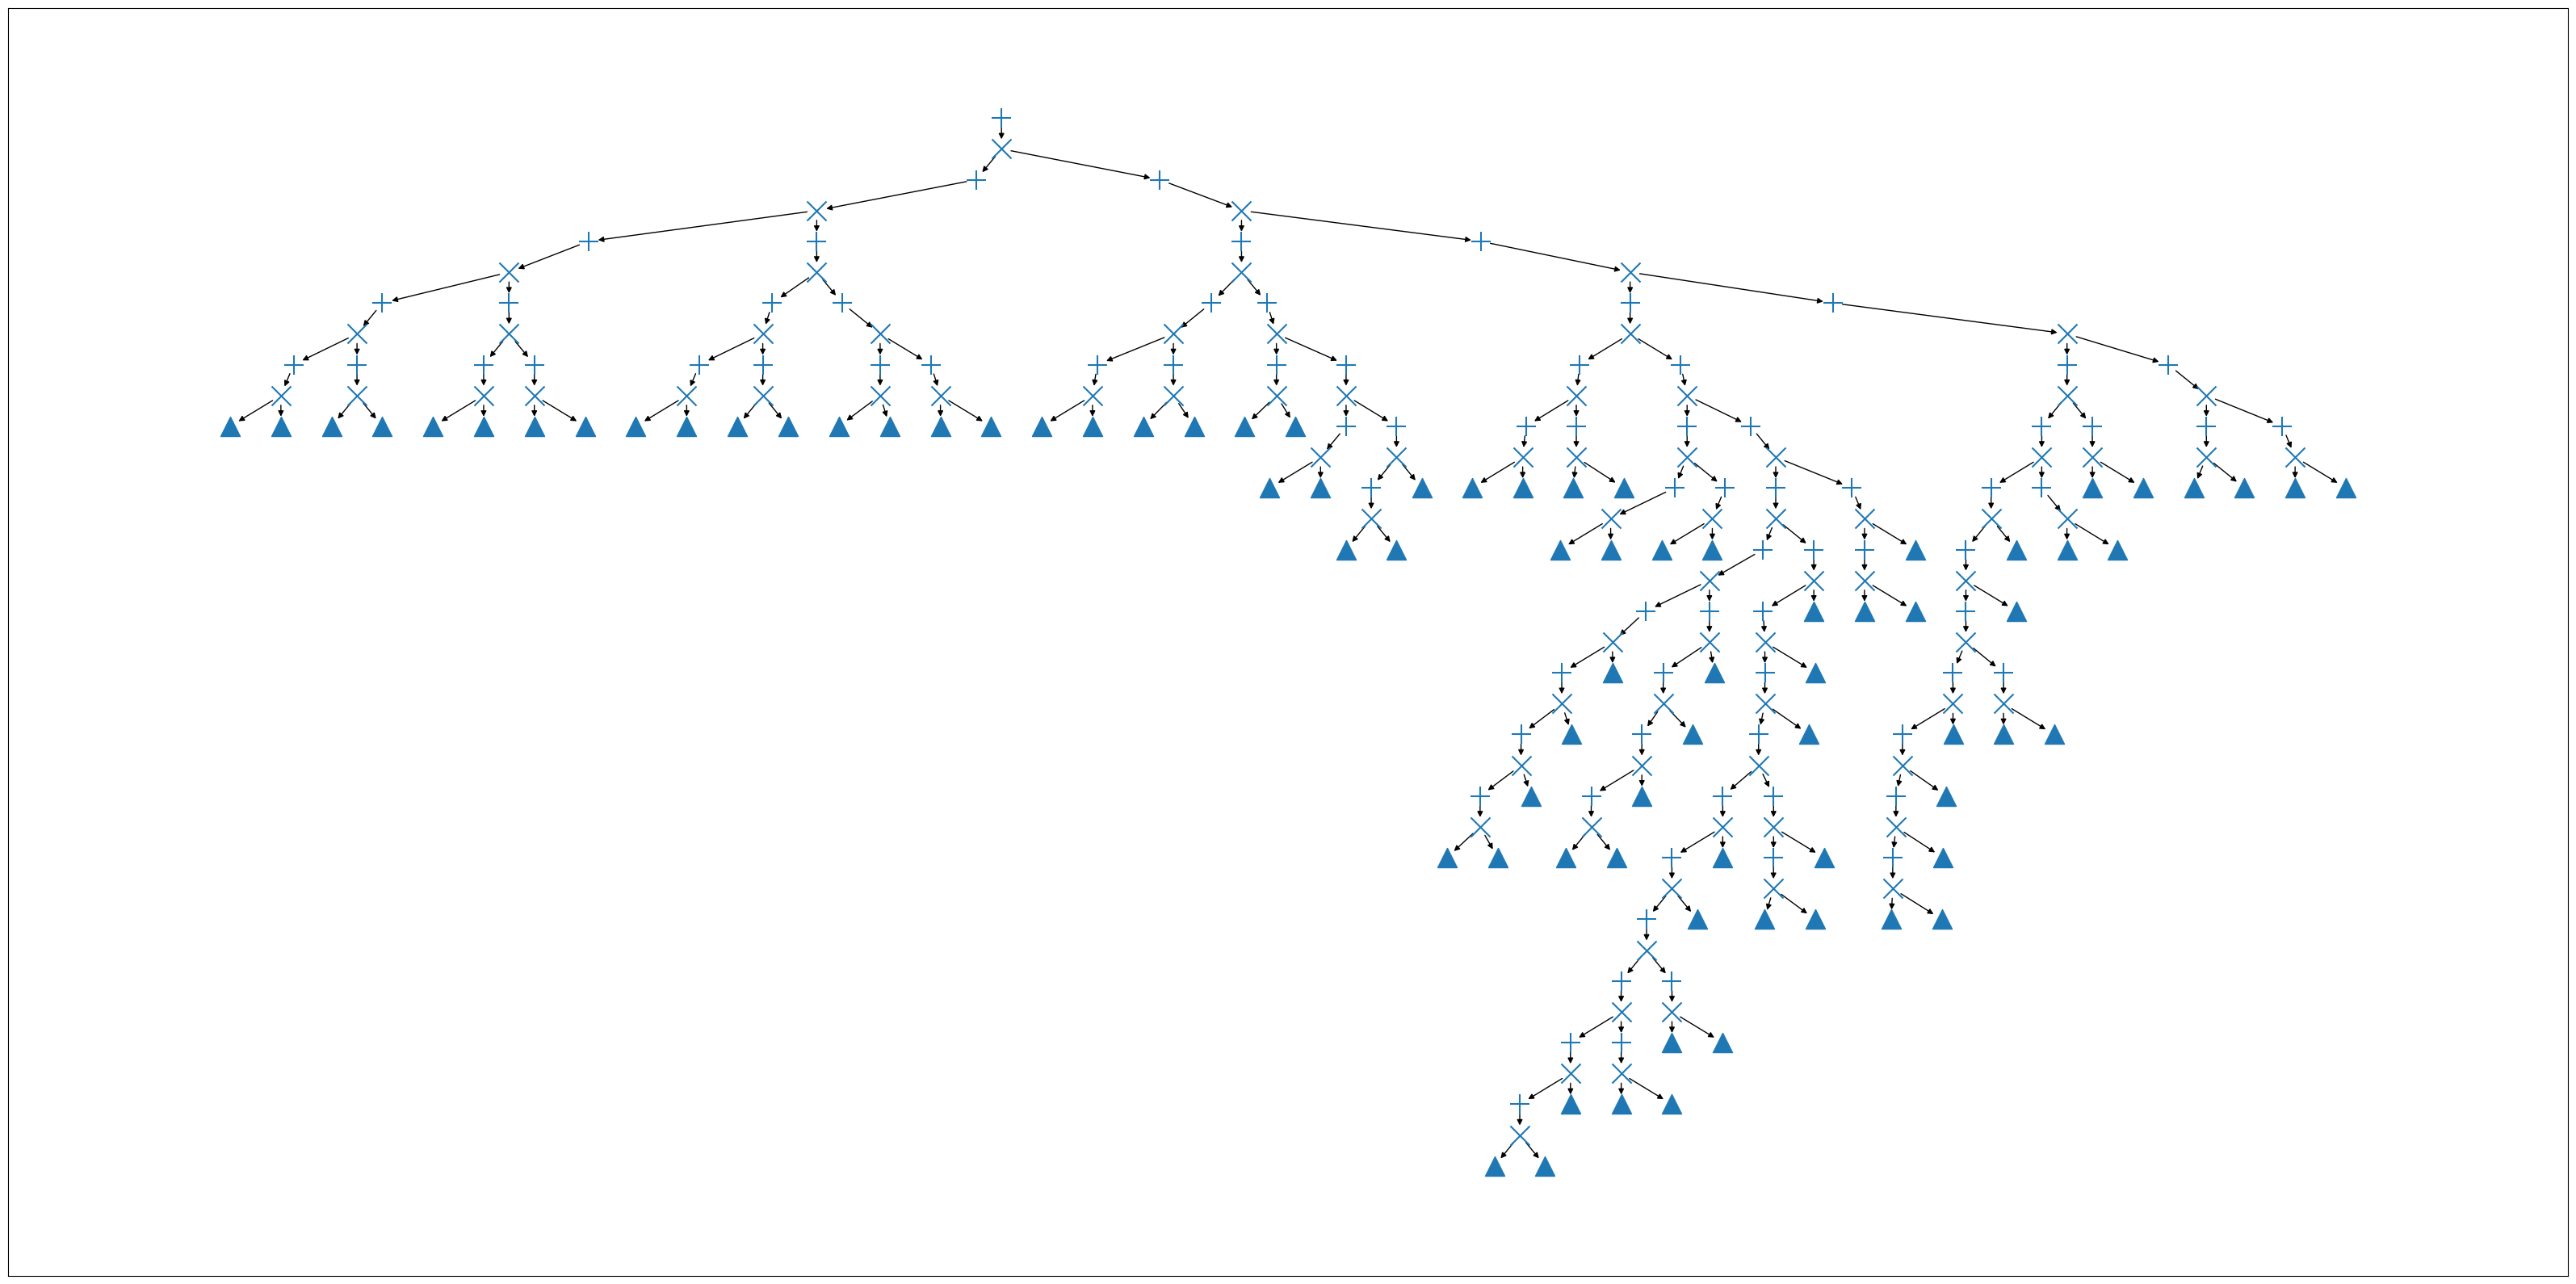

In [12]:
plt.figure(figsize=(32, 16))

pos = nx.nx_agraph.graphviz_layout(RG, "dot")
nx.draw_networkx_nodes(RG, pos, Graph.get_leaves(RG), node_shape="^")
nx.draw_networkx_nodes(RG, pos, Graph.get_sums(RG), node_shape="+")
nx.draw_networkx_nodes(RG, pos, Graph.get_products(RG), node_shape="x")
nx.draw_networkx_edges(RG, pos)

plt.tight_layout()
plt.savefig("outputs/bin_g_rg.pdf")

In [13]:
import torch

torch.manual_seed(0)

from EinsumNetwork import EinsumNetwork
from utils.dataset import ObjectCooccurrenceCOCODataset

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset_train = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")
dataset_valid = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")

batch_size = 8196
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size,
    True,
    drop_last=True,
    num_workers=8,
    pin_memory=device == "cuda",
)
dataloader_train2 = torch.utils.data.DataLoader(
    dataset_train, batch_size, num_workers=8, pin_memory=device == "cuda"
)
dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size, num_workers=8, pin_memory=device == "cuda"
)

num_mixture = 5
max_num_epochs = 500
online_em_frequency = 1
online_em_stepsize = 1e-1
if dataloader_train.drop_last:
    online_em_stepsize = 1 / len(dataloader_train)
    # online_em_frequency = len(dataloader_train) - 1

In [14]:
args = EinsumNetwork.Args(
    num_classes=1,
    num_input_distributions=num_mixture,
    exponential_family=EinsumNetwork.CategoricalArray,
    exponential_family_args={"K": 29},
    num_sums=num_mixture,
    num_var=df_train.shape[1],
    online_em_frequency=online_em_frequency,
    online_em_stepsize=online_em_stepsize,
)

einet = EinsumNetwork.EinsumNetwork(RG, args)
einet.initialize()

einet = einet.to(device)

print(einet)
print("Model size:\t{:,}".format(sum(p.numel() for p in einet.parameters())))

EinsumNetwork(
  (einet_layers): ModuleList(
    (0): FactorizedLeafLayer(
      (ef_array): CategoricalArray()
    )
    (1-17): 17 x EinsumLayer()
  )
)
Model size:	21,375


In [15]:
for p in einet.parameters():
    print(p.size())

torch.Size([80, 5, 1, 29])
torch.Size([5, 5, 5, 1])
torch.Size([5, 5, 5, 2])
torch.Size([5, 5, 5, 2])
torch.Size([5, 5, 5, 1])
torch.Size([5, 5, 5, 3])
torch.Size([5, 5, 5, 5])
torch.Size([5, 5, 5, 4])
torch.Size([5, 5, 5, 5])
torch.Size([5, 5, 5, 4])
torch.Size([5, 5, 5, 4])
torch.Size([5, 5, 5, 7])
torch.Size([5, 5, 5, 10])
torch.Size([5, 5, 5, 16])
torch.Size([5, 5, 5, 8])
torch.Size([5, 5, 5, 4])
torch.Size([5, 5, 5, 2])
torch.Size([5, 5, 1, 1])


In [16]:
inputs = next(iter(dataloader_train))
import utils

In [17]:
inputs = inputs.to(device)
outputs = einet(inputs)

ll_sample = EinsumNetwork.log_likelihoods(outputs)
log_likelihood = ll_sample.sum()

objective = log_likelihood
objective.backward()
utils.record_gradient_norm(einet)

{'einet_layers.1.params': 24769.208984375,
 'einet_layers.2.params': 29930.01171875,
 'einet_layers.3.params': 29345.3046875,
 'einet_layers.4.params': 18737.236328125,
 'einet_layers.5.params': 36013.08203125,
 'einet_layers.6.params': 48040.73046875,
 'einet_layers.7.params': 43650.890625,
 'einet_layers.8.params': 45095.51171875,
 'einet_layers.9.params': 42987.96875,
 'einet_layers.10.params': 44400.171875,
 'einet_layers.11.params': 57771.7734375,
 'einet_layers.12.params': 70880.46875,
 'einet_layers.13.params': 85958.34375,
 'einet_layers.14.params': 52192.89453125,
 'einet_layers.15.params': 36745.09765625,
 'einet_layers.16.params': 26350.20703125,
 'einet_layers.17.params': 40978.44140625}

In [21]:
grads

{'einet_layers.1.params': 74116.8828125,
 'einet_layers.2.params': 89784.5546875,
 'einet_layers.3.params': 88028.1484375,
 'einet_layers.4.params': 56212.7421875,
 'einet_layers.5.params': 108034.828125,
 'einet_layers.6.params': 144158.671875,
 'einet_layers.7.params': 130757.34375,
 'einet_layers.8.params': 135286.34375,
 'einet_layers.9.params': 128843.3046875,
 'einet_layers.10.params': 133176.421875,
 'einet_layers.11.params': 173350.71875,
 'einet_layers.12.params': 212553.0625,
 'einet_layers.13.params': 257904.8125,
 'einet_layers.14.params': 156579.34375,
 'einet_layers.15.params': 110235.203125,
 'einet_layers.16.params': 79050.6015625,
 'einet_layers.17.params': 122935.2421875}

In [ ]:
for epoch_count in (pbar := tqdm(range(1, max_num_epochs + 1), unit="epoch")):
    # evaluate
    train_ll = 0
    valid_ll = 0

    for inputs in dataloader_train:
        inputs = inputs.to(device)
        outputs = einet(inputs)

        ll_sample = EinsumNetwork.log_likelihoods(outputs)
        log_likelihood = ll_sample.sum()

        objective = log_likelihood
        objective.backward()
        einet.em_process_batch()

    with torch.inference_mode():
        for inputs in dataloader_train2:
            inputs = inputs.to(device)
            outputs = einet(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            train_ll = train_ll + log_likelihood.item()

        for inputs in dataloader_valid:
            inputs = inputs.to(device)
            outputs = einet(inputs)

            ll_sample = EinsumNetwork.log_likelihoods(outputs)
            log_likelihood = ll_sample.sum()

            valid_ll = valid_ll + log_likelihood.item()

    pbar.set_postfix_str(
        "Train NLL {:.4f}\tValid NLL {:.4f}".format(
            -train_ll / len(dataset_train),
            -valid_ll / len(dataset_valid),
        )
    )

  0%|          | 0/500 [00:00<?, ?epoch/s]